# Examen Modelos Computacionales II
## Anel Mendiola Velasco
26 Mayo 2025

In [13]:
!pip install tensorflow

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
              

Como no pude usar jupyter debido a que se necesita una versión más vieja de Python para poder usar tensorflow, decidí hacerlo en Google Collab ! :🇩

Funciona igual que jupyter, solo que en lugar de usar los archivos locales, tuve que subir los datasets a Google Drive

# Conectamos Drive con Google Collab

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Verificamos lo que hay en mi carpeta de dataset

In [51]:
!ls "/content/drive/MyDrive/dataset_brain_tumor"

'Brain Tumor'   TEST   TRAIN   VAL


## Vamos a usar las etiquetas (0 y 1) del CSV para dividir las imágenes en tumor y no tumor en sub-carpetas tanto en TRAIN como en VAL

In [65]:
import os
import shutil
import pandas as pd

# Cargar CSV
csv_path = "/content/drive/MyDrive/dataset_brain_tumor/Brain_Tumor.csv"
df = pd.read_csv(csv_path)

# Ruta base
train_dir = "/content/drive/MyDrive/dataset_brain_tumor/TRAIN"

# Crear carpetas de salida PARA TRAIN - vamos a dividir en tumor y no tumor usando las etiquetas del CSV
os.makedirs(os.path.join(train_dir, "tumor"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "no_tumor"), exist_ok=True)

# Mover imágenes
for _, row in df.iterrows():
    image_name = row["Image"] + ".jpg"  # Cambia a .png si es necesario
    class_label = row["Class"]
    src_path = os.path.join(train_dir, image_name)
    if os.path.exists(src_path):
        if class_label == 1:
            dst_path = os.path.join(train_dir, "tumor", image_name)
        else:
            dst_path = os.path.join(train_dir, "no_tumor", image_name)
        shutil.move(src_path, dst_path)


## Hacemos lo mismo de arriba, pero con la carpeta de VAL

In [71]:
import os
import shutil
import pandas as pd

# Cargar CSV
csv_path = "/content/drive/MyDrive/dataset_brain_tumor/Brain_Tumor.csv"
df = pd.read_csv(csv_path)
df["filename"] = df["Image"] + ".jpg"

# Directorio VAL
val_dir = "/content/drive/MyDrive/dataset_brain_tumor/VAL"
tumor_dir = os.path.join(val_dir, "tumor")
no_tumor_dir = os.path.join(val_dir, "no_tumor")

os.makedirs(tumor_dir, exist_ok=True)
os.makedirs(no_tumor_dir, exist_ok=True)

# Mover imágenes según etiqueta
for _, row in df.iterrows():
    img_name = row["filename"]
    label = row["Class"]
    src = os.path.join(val_dir, img_name)
    if os.path.exists(src):
        dst = os.path.join(tumor_dir if label == 1 else no_tumor_dir, img_name)
        shutil.move(src, dst)

# Establecemos los directorios y vemos cuántas imágenes hay por clase

In [72]:
train_dir = "/content/drive/MyDrive/dataset_brain_tumor/TRAIN"
val_dir = "/content/drive/MyDrive/dataset_brain_tumor/VAL"
test_dir = "/content/drive/MyDrive/dataset_brain_tumor/TEST"

# Normalización y aumento
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(train_dir, target_size=(150, 150), class_mode='binary', batch_size=32)
val_gen = datagen.flow_from_directory(val_dir, target_size=(150, 150), class_mode='binary', batch_size=32)

Found 2633 images belonging to 2 classes.
Found 565 images belonging to 2 classes.


# Preparamos los datos

In [75]:
## Preparamos los generadores de datos

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalización de imágenes
datagen = ImageDataGenerator(rescale=1./255)

train_dir = "/content/drive/MyDrive/dataset_brain_tumor/TRAIN"
val_dir = "/content/drive/MyDrive/dataset_brain_tumor/VAL"

# Cargar imágenes desde carpetas
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2633 images belonging to 2 classes.
Found 565 images belonging to 2 classes.


 # Contruimos CNN

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Para clasificación binaria
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

# Entrenamos el modelo:

In [77]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 540s 6s/step - accuracy: 0.7174 - loss: 0.6030 - val_accuracy: 0.8726 - val_loss: 0.3641
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8426 - loss: 0.3887 - val_accuracy: 0.8372 - val_loss: 0.3601
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8640 - loss: 0.3245 - val_accuracy: 0.9062 - val_loss: 0.2794
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8756 - loss: 0.2737 - val_accuracy: 0.8956 - val_loss: 0.2897
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9227 - loss: 0.2087 - val_accuracy: 0.9168 - val_loss: 0.2177
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9298 - loss: 0.1663 - val_accuracy: 0.9062 - val_loss: 0.2538
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9413 - loss: 0.1533 - val_accuracy: 0.9363 - val_loss: 0.2120
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.9491 - loss: 0.1161 - val_accuracy: 0.9363 - v

# Evaluamos el desempeño del modelo

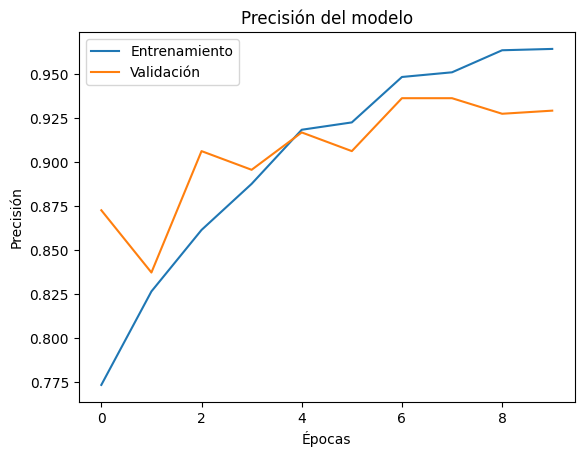

In [78]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()


Podemos ver que hay una diferencia entre entrenamiento y validación (96% vs 92.9%), lo que podría indicar ligero sobreajuste.

# Mejoramos el modelo

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.3),  # Ligero dropout
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

# ¿Qué cambiamos ahora?

*  Agregamos más bloques Conv2D + MaxPooling para que el modelo aprenda características más profundas.
*   BatchNormalization() acelera el entrenamiento, hace que el modelo sea más estable, nos ayuda a evitar el overfitting
*   Pusimos Dropout después de cada bloque convolucional y antes de la capa densa final
*   En vez de usar Flatten() (que crea vectores grandes y propensos a overfitting), usamos esta capa que reduce automáticamente cada mapa de características a un número promedio, también evita el sobreajuste
*   Un learning rate más bajo (0.0001) porque los modelos más profundos pueden volverse inestables con tasas altas

## Con esto logramos:


*   más convoluciones
*   que el modelo sea más estable
*   Espero que tenga menos sobreajuste y que haya más convergencia











In [85]:
history = model.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.7284 - loss: 0.5519 - val_accuracy: 0.8212 - val_loss: 0.4437
Epoch 2/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.8090 - loss: 0.4301 - val_accuracy: 0.8301 - val_loss: 0.3867
Epoch 3/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8449 - loss: 0.3613 - val_accuracy: 0.8212 - val_loss: 0.3814
Epoch 4/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8765 - loss: 0.3064 - val_accuracy: 0.9044 - val_loss: 0.2643
Epoch 5/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8820 - loss: 0.3053 - val_accuracy: 0.8991 - val_loss: 0.2563
Epoch 6/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8861 - loss: 0.2798 - val_accuracy: 0.9009 - val_loss: 0.2618
Epoch 7/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.8814 - loss: 0.2820 - val_accuracy: 0.9009 - val_loss: 0.2519
Epoch 8/15
83/83 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8896 - loss: 0.2647 - val_accuracy: 0.9062 - v

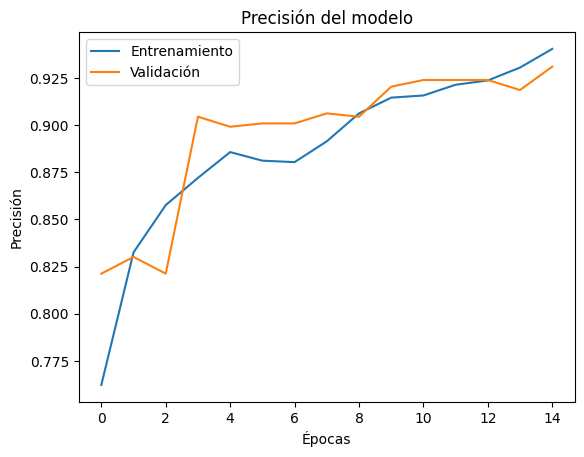

In [86]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

Podemos ver que la diferencia entre train y val ya es mínima, corregimos el overfitting. El modelo ya es más estable.

# Probamos con TEST

## acomodamos la carpeta de TEST

In [87]:
import os
import shutil
import pandas as pd

# Cargar CSV
csv_path = "/content/drive/MyDrive/dataset_brain_tumor/Brain_Tumor.csv"
df = pd.read_csv(csv_path)
df["filename"] = df["Image"] + ".jpg"

# Filtrar imágenes que están en TEST
test_filenames = os.listdir("/content/drive/MyDrive/dataset_brain_tumor/TEST")
df_test = df[df["filename"].isin(test_filenames)]

# Directorio TEST
test_dir = "/content/drive/MyDrive/dataset_brain_tumor/TEST"
tumor_dir = os.path.join(test_dir, "tumor")
no_tumor_dir = os.path.join(test_dir, "no_tumor")

os.makedirs(tumor_dir, exist_ok=True)
os.makedirs(no_tumor_dir, exist_ok=True)

# Mover imágenes según etiqueta
for _, row in df_test.iterrows():
    img_name = row["filename"]
    label = row["Class"]
    src = os.path.join(test_dir, img_name)
    if os.path.exists(src):
        dst = os.path.join(tumor_dir if label == 1 else no_tumor_dir, img_name)
        shutil.move(src, dst)


In [88]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/dataset_brain_tumor/TEST',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 564 images belonging to 2 classes.


In [89]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Accuracy: {test_accuracy:.4f} - Test Loss: {test_loss:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.8890 - loss: 0.2403
Test Accuracy: 0.9078 - Test Loss: 0.2106


Podemos observar que el modelo generaliza bien, la diferencia entre validación y test es mínima. No se observa un overfitting significativo y hay consistencia en la calidad de predicción.

# matriz de confusión

18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 972ms/step


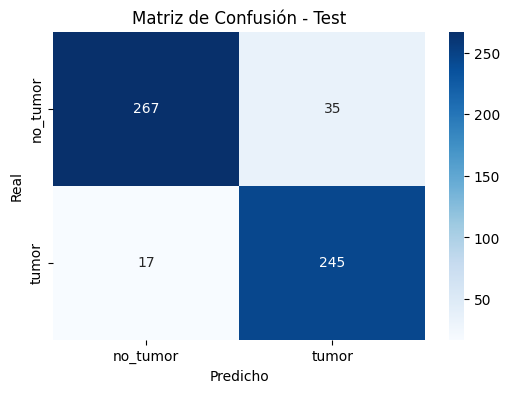

              precision    recall  f1-score   support

    no_tumor       0.94      0.88      0.91       302
       tumor       0.88      0.94      0.90       262

    accuracy                           0.91       564
   macro avg       0.91      0.91      0.91       564
weighted avg       0.91      0.91      0.91       564



In [90]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predicciones
y_pred = model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)

# Etiquetas reales
y_true = test_gen.classes

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Test')
plt.show()

# Reporte de clasificación
print(classification_report(y_true, y_pred_classes, target_names=labels))

# Comparación con otros modelos
## Aplicamos PCA primero


In [91]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from tqdm import tqdm

# Ruta base
base_dir = "/content/drive/MyDrive/dataset_brain_tumor"

# Función para cargar imágenes
def load_images_from_folder(folder):
    data = []
    labels = []
    for label, class_name in enumerate(["no_tumor", "tumor"]):
        class_folder = os.path.join(folder, class_name)
        for fname in os.listdir(class_folder):
            img_path = os.path.join(class_folder, fname)
            try:
                img = load_img(img_path, target_size=(150, 150), color_mode="grayscale")
                img_array = img_to_array(img).flatten() / 255.0  # Normalizar
                data.append(img_array)
                labels.append(label)
            except:
                pass  # Ignorar errores de lectura
    return np.array(data), np.array(labels)

# Cargar datasets
X_train, y_train = load_images_from_folder(os.path.join(base_dir, "TRAIN"))
X_val, y_val = load_images_from_folder(os.path.join(base_dir, "VAL"))
X_test, y_test = load_images_from_folder(os.path.join(base_dir, "TEST"))

# Combinar train y val para los modelos clásicos
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

# Reducir dimensionalidad con PCA
pca = PCA(n_components=100)
X_combined_pca = pca.fit_transform(X_combined)
X_test_pca = pca.transform(X_test)

# Entrenar y evaluar modelos
results = {}

# Haremos evaluación con SVM, KNN y Random Forest

In [92]:
# SVM
svm_model = SVC()
svm_model.fit(X_combined_pca, y_combined)
svm_preds = svm_model.predict(X_test_pca)
results["SVM"] = accuracy_score(y_test, svm_preds)

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_combined_pca, y_combined)
knn_preds = knn_model.predict(X_test_pca)
results["KNN"] = accuracy_score(y_test, knn_preds)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_combined_pca, y_combined)
rf_preds = rf_model.predict(X_test_pca)
results["Random Forest"] = accuracy_score(y_test, rf_preds)

results

{'SVM': 0.9095744680851063,
 'KNN': 0.9273049645390071,
 'Random Forest': 0.925531914893617}

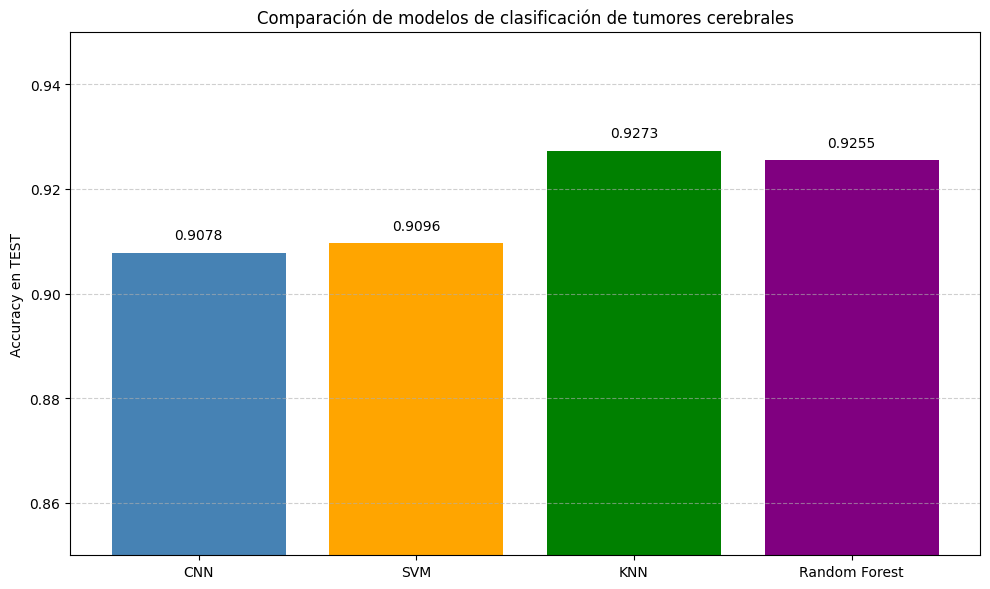

In [94]:
import matplotlib.pyplot as plt

# Resultados obtenidos
model_names = ["CNN", "SVM", "KNN", "Random Forest"]
accuracies = [0.9078, 0.9096, 0.9273, 0.9255]

# Crear gráfica de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=["steelblue", "orange", "green", "purple"])
plt.ylim(0.85, 0.95)
plt.ylabel("Accuracy en TEST")
plt.title("Comparación de modelos de clasificación de tumores cerebrales")

# Añadir etiquetas encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.002, f"{height:.4f}",
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Análisis de resultados

La red que entrené alcanzó un resultado del 90.78%. KNN fue el que mejor se desempeó con un 92.73%, le siguió random forest.

Puede que hayan sido mejores porque la extracción de características con PCA fue efectiva. Al tener las clases bien separadas hubo mejor rendimiento.

CNN es bueno si queremos que aprenda directamente de las imágenes.